In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/PhamdinhKhanhcode")

In [3]:
!git clone https://github.com/zhixuhao/unet.git

fatal: destination path 'unet' already exists and is not an empty directory.


các file huấn luyện được để trong thư mục `data/membrane` bao gồm :



*   Folder `image`: chứa hình ảnh huấn luyện
*   Foder `label`: chứa nhãn của dữ liệu



In [4]:
import glob2

# function glob2.glob trả về một list chứa các đường đẫn thuộc kiểu string đến từng phần tử đó

image5_path = sorted(glob2.glob("unet/data/membrane/train/image/*.png")[:5])
label5_path = sorted(glob2.glob("unet/data/membrane/train/label/*.png")[:5])



Visulize 5 phần tử đầu tiên của tập huấn luyện và nhãn tương ứng của chúng

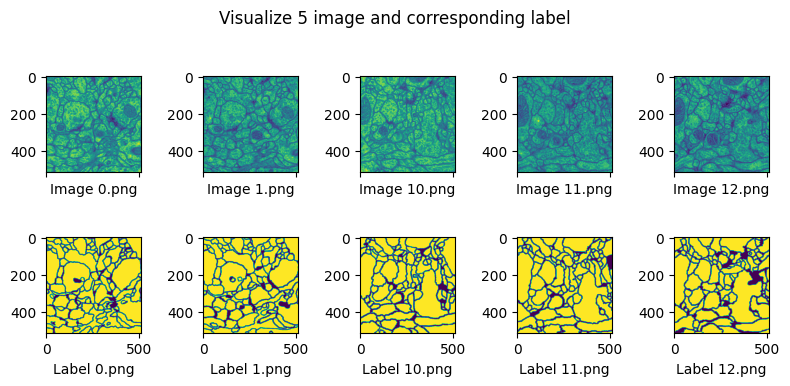

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

fig, ax = plt.subplots(figsize=(8,4), nrows = 2, ncols=5, sharex=True)
fig.suptitle("Visualize 5 image and corresponding label")

for i, image_path in enumerate(image5_path):
  image = plt.imread(image_path)
  ax[0,i].set_xlabel("Image " + image_path.split("/")[-1])
  ax[0,i].imshow(image)

for i, label_path in enumerate(label5_path):
  label = plt.imread(label_path)
  ax[1,i].set_xlabel("Label "+ label_path.split("/")[-1])
  ax[1,i].imshow(label)

plt.tight_layout()
plt.show()

Nhãn 0 là các vị trí thuộc dây thần kinh, nhãn 1 là vị trí thuộc vùng nền.

Ta có thể thấy ở ảnh label các giá trị nhiễu đã được loại bỏ. Ảnh chỉ còn giữ lại dây thần kinh và vùng nền, qua đó chúng ta thu được một map cấu trúc của hệ thần kinh bụng ấu trùng Drosophia rõ ràng hơn.


![](https://imgur.com/lKZGO0C.png)

**Kiến trúc mô hình Unet. Mỗi một thanh chữ nhật màu xanh là một feature map đa kênh. Kích thước width x height được kí hiệu góc trái bên dưới của thanh chữ nhật và số lượng channels được kí hiệu trên đỉnh của feature map. Các thanh chữ nhật màu trắng bên nhánh phải của hình chữ U được copy từ nhánh bên trái và concatenate vào nhánh bên phải. Mỗi một mũi tên có màu sắc khác nhau tương ứng với một phép biến đổi khác nhau như chúng ta có thể thấy trong mô tả của mạng.**

Mạng Unet bao gồm 2 nhánh đối xứng nhau hình chữ U nên được gọi là Unet.

Kiến trúc mạng Unet bao gồm 2 phần là **phần thu hẹp (contraction)** ở bên trái và **phần mở rộng (expansion)** ở bên phải. Mỗi phần sẽ thực hiện một nhiệm vụ riêng như sau:

* Phần thu hẹp: Làm nhiệm vụ trích lọc đặc trưng để tìm ra bối cảnh của hình ảnh. Vai trò của phần thu hẹp tương tự như một Encoder. Một mạng Deep CNN sẽ đóng vai trò trích lọc đặc trưng. Lý do nhánh được gọi là thu hẹp vì kích thước dài và rộng của các layers giảm dần. Từ input kích thước 572x572 chỉ còn 32x32. Đồng thời độ sâu cũng tăng dần từ 3 lên 512.

* Phần mở rộng: Gồm các layer đối xứng tương ứng với các layer của nhánh thu hẹp. Quá trình Upsampling được áp dụng giúp cho kích thước layer tăng dần lên. Sau cùng ta thu được một ảnh mask đánh dấu nhãn dự báo của từng pixel.

Đặc trưng riêng trong cấu trúc của Unet đó là áp dụng kết nối tắt đối xứng giữa layer bên trái với layer bên phải.

Mặc dù có độ chính xác khá cao nhưng Unet có tốc độ thấp. Với kiến trúc Unet cho input 572x572 như bài báo gốc có tốc độ là 5 fps. Do đó nó không phù hợp để áp dụng vào các tác vụ yêu cầu realtime như xe tự hành. Tuy nhiên, Unet lại thường được sử dụng khá phổ biến trong các tác vụ không đòi hỏi realtime vì accuracy của nó cũng không tồi và kiến trúc dễ implement.

## 1.1. Xây dựng và Huấn luyện mô hình Unet Chuẩn theo bài báo

In [6]:
import tensorflow as tf
INPUT_SHAPE = 572
OUTPUT_SHAPE = 386

def _downsample_cnn_block(block_input, channel, is_first = False):
  if is_first:
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(block_input)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(maxpool)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
    return [maxpool, conv1, conv2]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):
  # Upsampling block
  uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
  # Crop block counterpart
  shape_input = uppool1.shape[2]
  shape_counterpart = block_counterpart.shape[2]
  crop_size = int((shape_counterpart-shape_input)/2)
  block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
  concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
  conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(concat)
  conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
  if is_last:
    conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, activation='sigmoid')(conv2)
    return [concat, conv1, conv2, conv3]
  return [uppool1, concat, conv1, conv2]

from tensorflow.keras.optimizers import Adam

def _create_model():
  ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)), channel=64, is_first = True)
  ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
  us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model = _create_model()

In [7]:
from sklearn.model_selection import train_test_split
import glob2

image_augs = glob2.glob('unet/data/membrane/train/aug/*.png')
label_path_aug = [item for item in image_augs if 'mask_' in item]
image_names = [item.split('/')[-1] for item in label_path_aug]
image_path_aug = ['unet/data/membrane/train/aug/image'+item[4:] for item in image_names]

image_paths = glob2.glob('unet/data/membrane/train/image/*.png')
label_paths = ['unet/data/membrane/train/label/' + path.split('/')[-1] for path in image_paths]

image_paths += image_path_aug
label_paths += label_path_aug

train_img_paths, val_img_paths, train_label_paths, val_label_paths = train_test_split(image_paths, label_paths, test_size = 0.2)

In [9]:
import cv2
import numpy as np

def _image_read_paths(train_img_paths, train_label_paths):
  X, Y = [], []
  for image_path, label_path in zip(train_img_paths, train_label_paths):
    image = cv2.imread(image_path)
    image_resize = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    label = cv2.imread(train_label_paths[0])
    label_gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label_resize = cv2.resize(label_gray, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label_binary = np.array(label_resize == 255).astype('float32')
    label_binary = label_binary[..., np.newaxis]
    X.append(image_resize)
    Y.append(label_binary)
  X = np.stack(X)
  Y = np.stack(Y)
  return X, Y

X_train, Y_train = _image_read_paths(train_img_paths, train_label_paths)
print(X_train.shape, Y_train.shape)
X_val, Y_val = _image_read_paths(val_img_paths, val_label_paths)
print(X_val.shape, Y_val.shape)

(72, 572, 572, 3) (72, 386, 386, 1)
(18, 572, 572, 3) (18, 386, 386, 1)


In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

history=model.fit(X_train, Y_train,
  validation_data = (X_val, Y_val),
  batch_size = 8,
  epochs = 100,
  callbacks = (EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))
  # callbacks = [lr_callback]
)

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/100
9/9 [==============================] - 15s 2s/step - loss: 437650.3438 - accuracy: 0.5095 - val_loss: 912679.3750 - val_accuracy: 0.6732
Epoch 2/100
9/9 [==============================] - 15s 2s/step - loss: 419914.4375 - accuracy: 0.4911 - val_loss: 335965.6875 - val_accuracy: 0.4993
Epoch 3/100
9/9 [==============================] - 16s 2s/step - loss: 283614.0000 - accuracy: 0.5766 - val_loss: 86399.6484 - val_accuracy: 0.4943
Epoch 4/100
9/9 [==============================] - 15s 2s/step - loss: 33319.4219 - accuracy: 0.5530 - val_loss: 17173.6016 - val_accuracy: 0.6736
Epoch 5/100
9/9 [==============================] - 15s 2s/step - loss: 14054.4307 - accuracy: 0.5183 - val_loss: 7185.7256 - val_accuracy: 0.6704
Epoch 6/100
9/9 [==============================] - 15s 2s/step - loss: 7589.6899 - accuracy: 0.6308 - val_loss: 2438.5862 - val_accuracy: 0.6728
Epoch 7/100
9/9 [==============================] - 15s 2s/step - loss: 2470.2705 - accuracy: 0.5314 - val_loss: 1445

<ipython-input-13-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


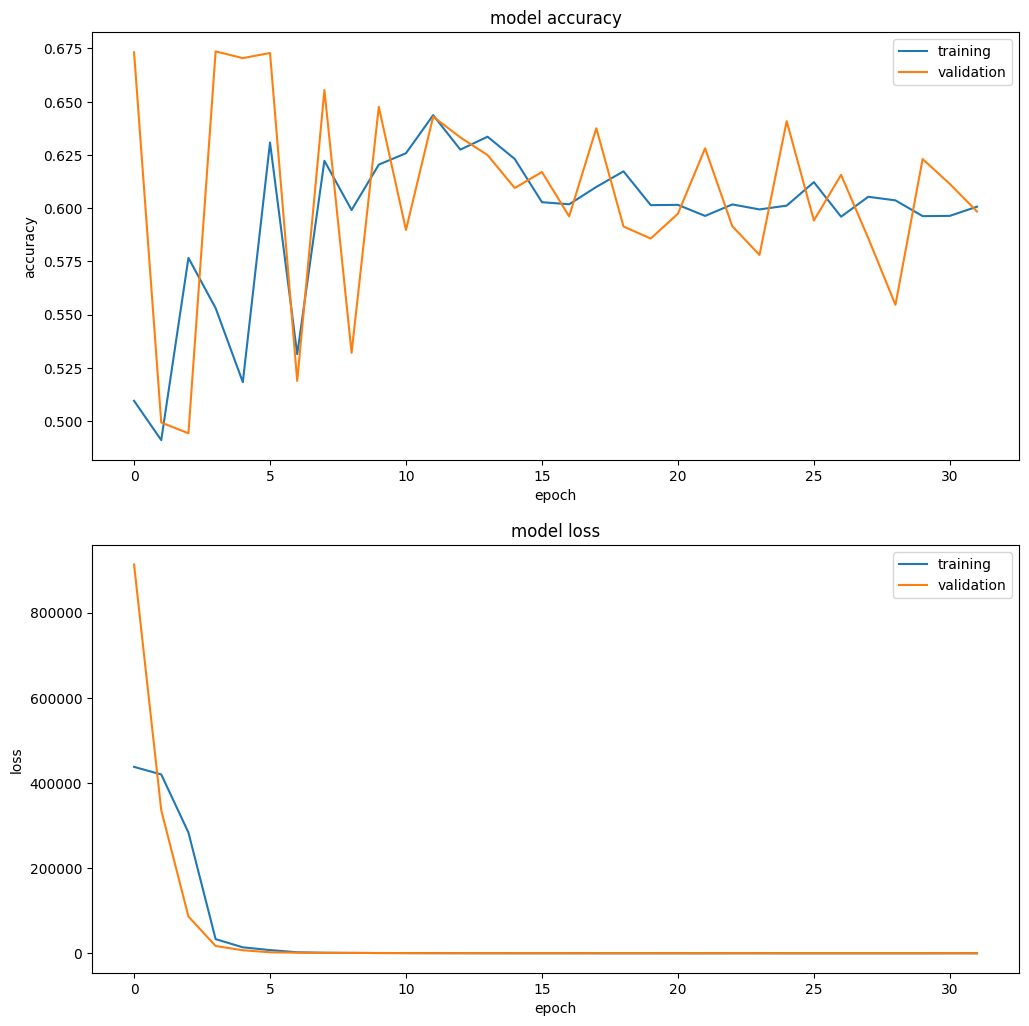

In [13]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [14]:
import tensorflow as tf

INPUT_SHAPE = 512
OUTPUT_SHAPE = 512

def _downsample_cnn_block(block_input, channel, is_first = False):
  if is_first:
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(block_input)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(maxpool)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
    return [maxpool, conv1, conv2]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):
  # Upsampling block
  uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
  # Crop block counterpart
  shape_input = uppool1.shape[2]
  shape_counterpart = block_counterpart.shape[2]
  crop_size = int((shape_counterpart-shape_input)/2)
  # Có thể bỏ qua crop vì các nhánh đã bằng kích thước.
  block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
  concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
  conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(concat)
  conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1, padding='same')(conv1)
  if is_last:
    conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(conv2)
    return [concat, conv1, conv2, conv3]
  return [uppool1, concat, conv1, conv2]

In [15]:
from tensorflow.keras.optimizers import Adam

def _create_model2():
  ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)), channel=64, is_first = True)
  ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
  us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model2 = _create_model2()

In [16]:
import cv2

def _image_read_paths(train_img_paths, train_label_paths):
  X, Y = [], []
  for image_path, label_path in zip(train_img_paths, train_label_paths):
    image = cv2.imread(image_path)
    image_resize = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    label = cv2.imread(train_label_paths[0])
    label_gray = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label_resize = cv2.resize(label_gray, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label_binary = np.array(label_resize == 255).astype('float32')
    label_binary = label_binary[..., np.newaxis]
    # label_first_cn = np.array(label_resize == 255).astype('float32')
    # label_second_cn = np.array(label_resize == 0).astype('float32')
    # label_binary = np.stack([label_first_cn, label_second_cn], axis = 2)
    X.append(image_resize)
    Y.append(label_binary)
  X = np.stack(X)
  Y = np.stack(Y)
  return X, Y

X_train, Y_train = _image_read_paths(train_img_paths, train_label_paths)
print(X_train.shape, Y_train.shape)
X_val, Y_val = _image_read_paths(val_img_paths, val_label_paths)
print(X_val.shape, Y_val.shape)

(72, 512, 512, 3) (72, 512, 512, 1)
(18, 512, 512, 3) (18, 512, 512, 1)


In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

history=model2.fit(X_train, Y_train,
  validation_data = (X_val, Y_val),
  batch_size = 8,
  epochs = 100,
  callbacks = (EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True))
)

Epoch 1/100
9/9 [==============================] - 114s 4s/step - loss: 145131.0625 - accuracy: 0.4472 - val_loss: 8419293.0000 - val_accuracy: 0.2831
Epoch 2/100
9/9 [==============================] - 18s 2s/step - loss: 5953444.5000 - accuracy: 0.4161 - val_loss: 1328647.2500 - val_accuracy: 0.6440
Epoch 3/100
9/9 [==============================] - 19s 2s/step - loss: 60715364.0000 - accuracy: 0.4588 - val_loss: 1909467.3750 - val_accuracy: 0.6152
Epoch 4/100
9/9 [==============================] - 17s 2s/step - loss: 13798768.0000 - accuracy: 0.5473 - val_loss: 5534883.0000 - val_accuracy: 0.6146


<ipython-input-18-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


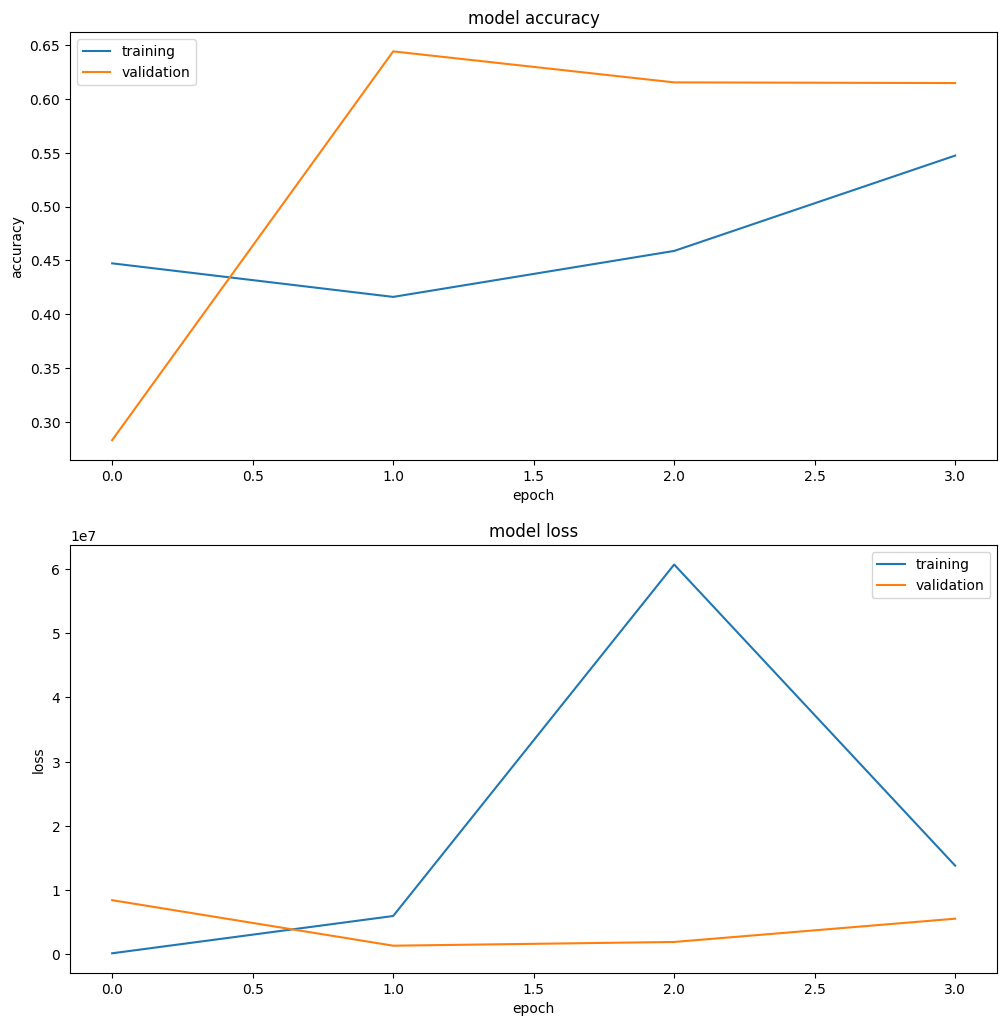

In [18]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)